In [65]:
import pandas as pd

In [66]:
df = pd.read_csv('Means_Combined.csv')
df.head()




,Experiment,Section,Variable,Source,Model,ScalarName,AnalysisType,Region,ScalarType,Units,Data,Weight
0,co2,CarbonStocks,CarboninVegetation,ENSMEAN,co2_-100pct,Benchmark Period Mean (intersection),MeanState,global,scalar,g m-2,2557.83,1
1,co2,CarbonStocks,CarboninVegetation,ENSMEAN,co2_-100pct,Model Period Mean (intersection),MeanState,global,scalar,g m-2,2680.74,1
2,co2,CarbonStocks,CarboninVegetation,ENSMEAN,co2_-100pct,Benchmark Period Mean (intersection),MeanState,tropics,scalar,g m-2,4373.37,1
3,co2,CarbonStocks,CarboninVegetation,ENSMEAN,co2_-100pct,Model Period Mean (intersection),MeanState,tropics,scalar,g m-2,3654.92,1
4,co2,CarbonStocks,CarboninVegetation,ENSMEAN,co2_-100pct,Benchmark Period Mean (intersection),MeanState,subtropics,scalar,g m-2,1636.48,1


# General Formatting

In [67]:
df.drop(columns=['Section','Source','AnalysisType', 'ScalarType', 'Weight'], inplace=True)

df.loc[df['ScalarName'] == 'Benchmark Period Mean (intersection)', 'ScalarName'] = 'Benchmark'
df.loc[df['ScalarName'] == 'Model Period Mean (intersection)', 'ScalarName'] = 'Model'
df = df.rename(columns={'ScalarName': 'Type'})

# --- Drop duplicate Benchmark rows per (Variable, Region) --- #
mask_bench = df['Type'] == 'Benchmark'

# Mark duplicates only among Benchmark rows
dupes_bench = df[mask_bench].duplicated(subset=['Variable', 'Region'], keep='first')

# Drop those duplicates, keep everything else
df = df[~(mask_bench & dupes_bench)]

# Optional: sort for nicer viewing
df = df.sort_values(['Variable', 'Region', 'Type'])

print(df)

     Experiment                  Variable                  Model       Type  \
1598        pre    AutotrophicRespiration   pre_spfh_minus_90pct  Benchmark   
1599        pre    AutotrophicRespiration   pre_spfh_minus_90pct      Model   
1609        pre    AutotrophicRespiration   pre_spfh_minus_80pct      Model   
1619        pre    AutotrophicRespiration   pre_spfh_minus_70pct      Model   
1629        pre    AutotrophicRespiration   pre_spfh_minus_50pct      Model   
...         ...                       ...                    ...        ...   
1983        pre  TotalSoilMoistureContent   pre_spfh_minus_20pct      Model   
1993        pre  TotalSoilMoistureContent    pre_spfh_minus_0pct      Model   
2003        pre  TotalSoilMoistureContent   pre_spfh_minus_60pct      Model   
2013        pre  TotalSoilMoistureContent   pre_spfh_minus_40pct      Model   
2023        pre  TotalSoilMoistureContent  pre_spfh_minus_100pct      Model   

       Region      Units        Data  
1598   borea

### Experiment specific formatting

In [68]:
# --- 1. CO₂ experiment ---
co2_mask = df['Experiment'] == 'co2'

# Extract signed percentage before "pct"
co2_str = df.loc[co2_mask, 'Model'].astype(str)
pct = co2_str.str.extract(r'([-+]?\d+)(?=pct$)', expand=False)

# Only keep rows where we actually matched something
valid_co2 = pct.notna()
pct_int = pct[valid_co2].astype(int)

# Convert to absolute CO₂ concentration for those rows
df.loc[co2_mask & valid_co2, 'Model'] = 300 * (1 + pct_int / 100.0)


# --- 2. PRE (humidity etc.) experiment ---
pre_mask = df['Experiment'] == 'pre'

pre_str = df.loc[pre_mask, 'Model'].astype(str)
pct_pre = pre_str.str.extract(r'(\d+)(?=pct$)', expand=False)

valid_pre = pct_pre.notna()
df.loc[pre_mask & valid_pre, 'Model'] = pct_pre[valid_pre].astype(int)


# --- 3. Benchmark: force Model to 0 where Type == 'benchmark' ---
bench_mask = df['Type'] == 'benchmark'
df.loc[bench_mask, 'Model'] = 0

print(df[df['Experiment'].isin(['pre'])])

     Experiment                  Variable Model       Type   Region  \
1598        pre    AutotrophicRespiration    90  Benchmark   boreal   
1599        pre    AutotrophicRespiration    90      Model   boreal   
1609        pre    AutotrophicRespiration    80      Model   boreal   
1619        pre    AutotrophicRespiration    70      Model   boreal   
1629        pre    AutotrophicRespiration    50      Model   boreal   
...         ...                       ...   ...        ...      ...   
1983        pre  TotalSoilMoistureContent    20      Model  tropics   
1993        pre  TotalSoilMoistureContent     0      Model  tropics   
2003        pre  TotalSoilMoistureContent    60      Model  tropics   
2013        pre  TotalSoilMoistureContent    40      Model  tropics   
2023        pre  TotalSoilMoistureContent   100      Model  tropics   

          Units        Data  
1598  g m-2 d-1    0.518071  
1599  g m-2 d-1    0.550513  
1609  g m-2 d-1    0.553367  
1619  g m-2 d-1    0.555803

In [69]:
import matplotlib.pyplot as plt

# Your metadata dict
output_attributes = {
    "nbp":  "Net Biome Productivity",
    "gpp":  "Gross Primary Production",
    "npp":  "Net Primary Production",
    "ra":   "Autotrophic Respiration",
    "rh":   "Heterotrophic Respiration",
    "fLuc": "Land-Use Change Emissions",
    "fFire":"Fire Emissions",

    "mrro": "Total Runoff",
    "evapotrans": "Evapotranspiration",

    "cLitter": "Carbon in Litter Pool",
    "cSoil":   "Carbon in Soil Pool",
    "cVeg":    "Carbon in Vegetation",
    "cTotal":  "Total Carbon in Ecosystem",
    "cTotal_monthly": "Total Carbon in Ecosystem",

    "mrso": "Total Soil Moisture Content",

    "lai": "Leaf Area Index",
    "lai_avh15c1": "Leaf Area Index",
    "lai_modis":   "Leaf Area Index",
}

# Map ILAMB variable labels to the keys in output_attributes
VARIABLE_TO_KEY = {
    "NetBiomeProductivity": "nbp",
    "GrossPrimaryProduction": "gpp",
    "NetPrimaryProduction": "npp",
    "AutotrophicRespiration": "ra",
    "HeterotrophicRespiration": "rh",
    "LandUseChangeEmissions": "fLuc",
    "FireEmissions": "fFire",
    "TotalRunoff": "mrro",
    "Evapotranspiration": "evapotrans",
    "CarboninLitterPool": "cLitter",
    "CarboninSoilPool": "cSoil",
    "CarboninVegetation": "cVeg",
    "TotalCarboninEcosystem": "cTotal",
    "SoilMoisture": "mrso",
    "LeafAreaIndex": "lai",
}

In [70]:
import json
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from cycler import cycler

# Minimal metadata: key -> long name
output_attributes = {
    "nbp":  "Net Biome Productivity",
    "gpp":  "Gross Primary Production",
    "npp":  "Net Primary Production",
    "ra":   "Autotrophic Respiration",
    "rh":   "Heterotrophic Respiration",
    "fLuc": "Land-Use Change Emissions",
    "fFire":"Fire Emissions",

    "mrro": "Total Runoff",
    "evapotrans": "Evapotranspiration",

    "cLitter": "Carbon in Litter Pool",
    "cSoil":   "Carbon in Soil Pool",
    "cVeg":    "Carbon in Vegetation",
    "cTotal":  "Total Carbon in Ecosystem",
    "cTotal_monthly": "Total Carbon in Ecosystem",

    "mrso": "Total Soil Moisture Content",

    "lai": "Leaf Area Index",
    "lai_avh15c1": "Leaf Area Index",
    "lai_modis":   "Leaf Area Index",
}

# Map ILAMB variable labels to the keys in output_attributes
VARIABLE_TO_KEY = {
    "NetBiomeProductivity": "nbp",
    "GrossPrimaryProduction": "gpp",
    "NetPrimaryProduction": "npp",
    "AutotrophicRespiration": "ra",
    "HeterotrophicRespiration": "rh",
    "LandUseChangeEmissions": "fLuc",
    "FireEmissions": "fFire",
    "TotalRunoff": "mrro",
    "Evapotranspiration": "evapotrans",
    "CarboninLitterPool": "cLitter",
    "CarboninSoilPool": "cSoil",
    "CarboninVegetation": "cVeg",
    "TotalCarboninEcosystem": "cTotal",
    "SoilMoisture": "mrso",
    "LeafAreaIndex": "lai",
}

STD_JSON_PATH = (
    "/Net/Groups/BGI/people/ecathain/"
    "TRENDY_Emulator_Scripts/NewModel/src/dataset/std_dict.json"
)

def plot_variable_response(df, variable, forcing_var="co2",
                           std_json_path=STD_JSON_PATH):
    """
    Plot Data vs Model for a given response variable.

    - Lines with circle markers for each Region where Type != 'Benchmark'
    - 'x' markers for Benchmark points in the same region colour (at 300 ppm)
    - Y label from output_attributes long_name + Units column
    - Vertical lines for the forcing_var distribution (from std_dict.json):
        * mean      -> black dashed
        * ±1 std    -> dark grey dashed
        * ±2 std    -> light grey dashed

    Parameters
    ----------
    df : pandas.DataFrame
        Must contain columns: ['Variable', 'Region', 'Type', 'Model', 'Data', 'Units', 'Experiment'].
    variable : str
        ILAMB variable label to plot (e.g. 'GrossPrimaryProduction', 'NetBiomeProductivity')
        or a key that can be mapped via VARIABLE_TO_KEY.
    forcing_var : str, default 'co2'
        Name of the forcing variable to look up in std_dict.json ('co2', 'tmp', or 'pre'),
        and to filter df['Experiment'].
    std_json_path : str
        Path to the std_dict.json file.
    """

    # ------------- Resolve variable label used in df -------------
    var_values = df['Variable'].unique()
    if variable in var_values:
        var_label = variable
    else:
        # Try mapping from a short key like "gpp"
        var_key = variable.lower()
        inv_map = {v.lower(): k for k, v in VARIABLE_TO_KEY.items()}
        if var_key in inv_map:
            var_label = inv_map[var_key]
        else:
            raise ValueError(
                f"Could not match variable '{variable}' to any df['Variable'] value "
                f"or VARIABLE_TO_KEY entry."
            )

    sub = df[df['Variable'] == var_label].copy()
    if sub.empty:
        raise ValueError(f"No rows found for Variable == '{var_label}'")

    # ------------- NEW: restrict to a single experiment -------------
    # Only keep rows where Experiment matches the forcing_var (e.g. 'co2')
    sub = sub[sub['Experiment'].str.lower() == forcing_var.lower()]
    if sub.empty:
        raise ValueError(
            f"No rows left after filtering for Experiment == '{forcing_var}'. "
            f"Check df['Experiment'] values."
        )

    # Units from the data
    units_vals = sub['Units'].dropna().unique()
    units = units_vals[0] if len(units_vals) > 0 else ""

    # Get long_name from output_attributes, if available
    key = VARIABLE_TO_KEY.get(var_label, None)
    if key is None:
        long_name = var_label
    else:
        long_name = output_attributes.get(key, var_label)

    # ------------- Figure + aesthetics -------------
    fig, ax = plt.subplots(figsize=(7.5, 4.5), dpi=300)

    # Muted, colour-blind-friendly palette
    palette = [
        "#4c72b0",  # blue
        "#55a868",  # green
        "#c44e52",  # red
        "#8172b3",  # purple
        "#ccb974",  # ochre
        "#64b5cd",  # light blue
        "#8c8c8c",  # grey
    ]
    ax.set_prop_cycle(cycler(color=palette))

    # Split model and benchmark rows
    model_rows = sub[sub['Type'] != 'Benchmark']
    bench_rows = sub[sub['Type'] == 'Benchmark']

    # ------------- Plot regional lines + benchmarks -------------
    regions = sorted(model_rows['Region'].dropna().unique())
    for region in regions:
        r_data = model_rows[model_rows['Region'] == region]
        if r_data.empty:
            continue

        r_data = r_data.sort_values('Model')

        # Line with hollow circle markers
        line, = ax.plot(
            r_data['Model'],
            r_data['Data'],
            marker='o',
            markersize=4.5,
            markerfacecolor='none',
            linewidth=1.8,
            linestyle='-',
            label=region.title(),  # capitalise in legend
        )
        color = line.get_color()

        # Benchmarks for this region at 300 ppm
        r_bench = bench_rows[bench_rows['Region'] == region]
        if not r_bench.empty:
            ax.plot(
                [300] * len(r_bench),
                r_bench['Data'],
                marker='x',
                linestyle='None',
                markersize=7,
                markeredgewidth=1.5,
                color=color,
            )

    # ------------- Vertical lines from std_dict.json -------------
    try:
        with open(std_json_path, "r") as f:
            std_dict = json.load(f)
    except FileNotFoundError:
        print(f"Warning: std_dict.json not found at {std_json_path}; "
              "skipping mean/std lines.")
        std_dict = {}

    forcing_key = forcing_var.lower()
    if forcing_key in std_dict:
        stats = std_dict[forcing_key]
        mean = stats["mean"]
        std = stats["std"]

        # Mean: black dashed
        ax.axvline(
            mean,
            color="black",
            linestyle="--",
            linewidth=1.2,
        )

        # ±1σ: dark grey
        for x in (mean - std, mean + std):
            ax.axvline(
                x,
                color="#555555",
                linestyle="--",
                linewidth=1.0,
            )

        # ±2σ: light grey
        for x in (mean - 2 * std, mean + 2 * std):
            ax.axvline(
                x,
                color="#bbbbbb",
                linestyle="--",
                linewidth=0.9,
            )
    else:
        print(f"Warning: '{forcing_key}' not found in std_dict.json; "
              "no mean/std lines drawn.")

    # ------------- Axes labels & grid -------------
    ax.set_xlabel(r"CO$_2$ concentration (ppm)", fontsize=11)
    if units:
        ax.set_ylabel(f"{long_name} [{units}]", fontsize=11)
    else:
        ax.set_ylabel(long_name, fontsize=11)

    ax.grid(True, alpha=0.3, linewidth=0.6)
    ax.tick_params(labelsize=9)

    # ------------- Legend (outside, with benchmark entry) -------------
    handles, labels = ax.get_legend_handles_labels()

    # Add a global benchmark legend entry (black "x")
    benchmark_handle = Line2D(
        [], [], color='black', marker='x', linestyle='None',
        markersize=7, markeredgewidth=1.5, label='TRENDY Mean (S0)'
    )

    handles = handles + [benchmark_handle]
    labels = labels + ['TRENDY Mean (S0)']

    ax.legend(
        handles=handles,
        labels=labels,
        loc='center left',
        bbox_to_anchor=(1.02, 0.5),
        borderaxespad=0.0,
        frameon=False,
        title="Region",
        title_fontsize=10,
        fontsize=9,
    )

    fig.tight_layout()
    return fig, ax

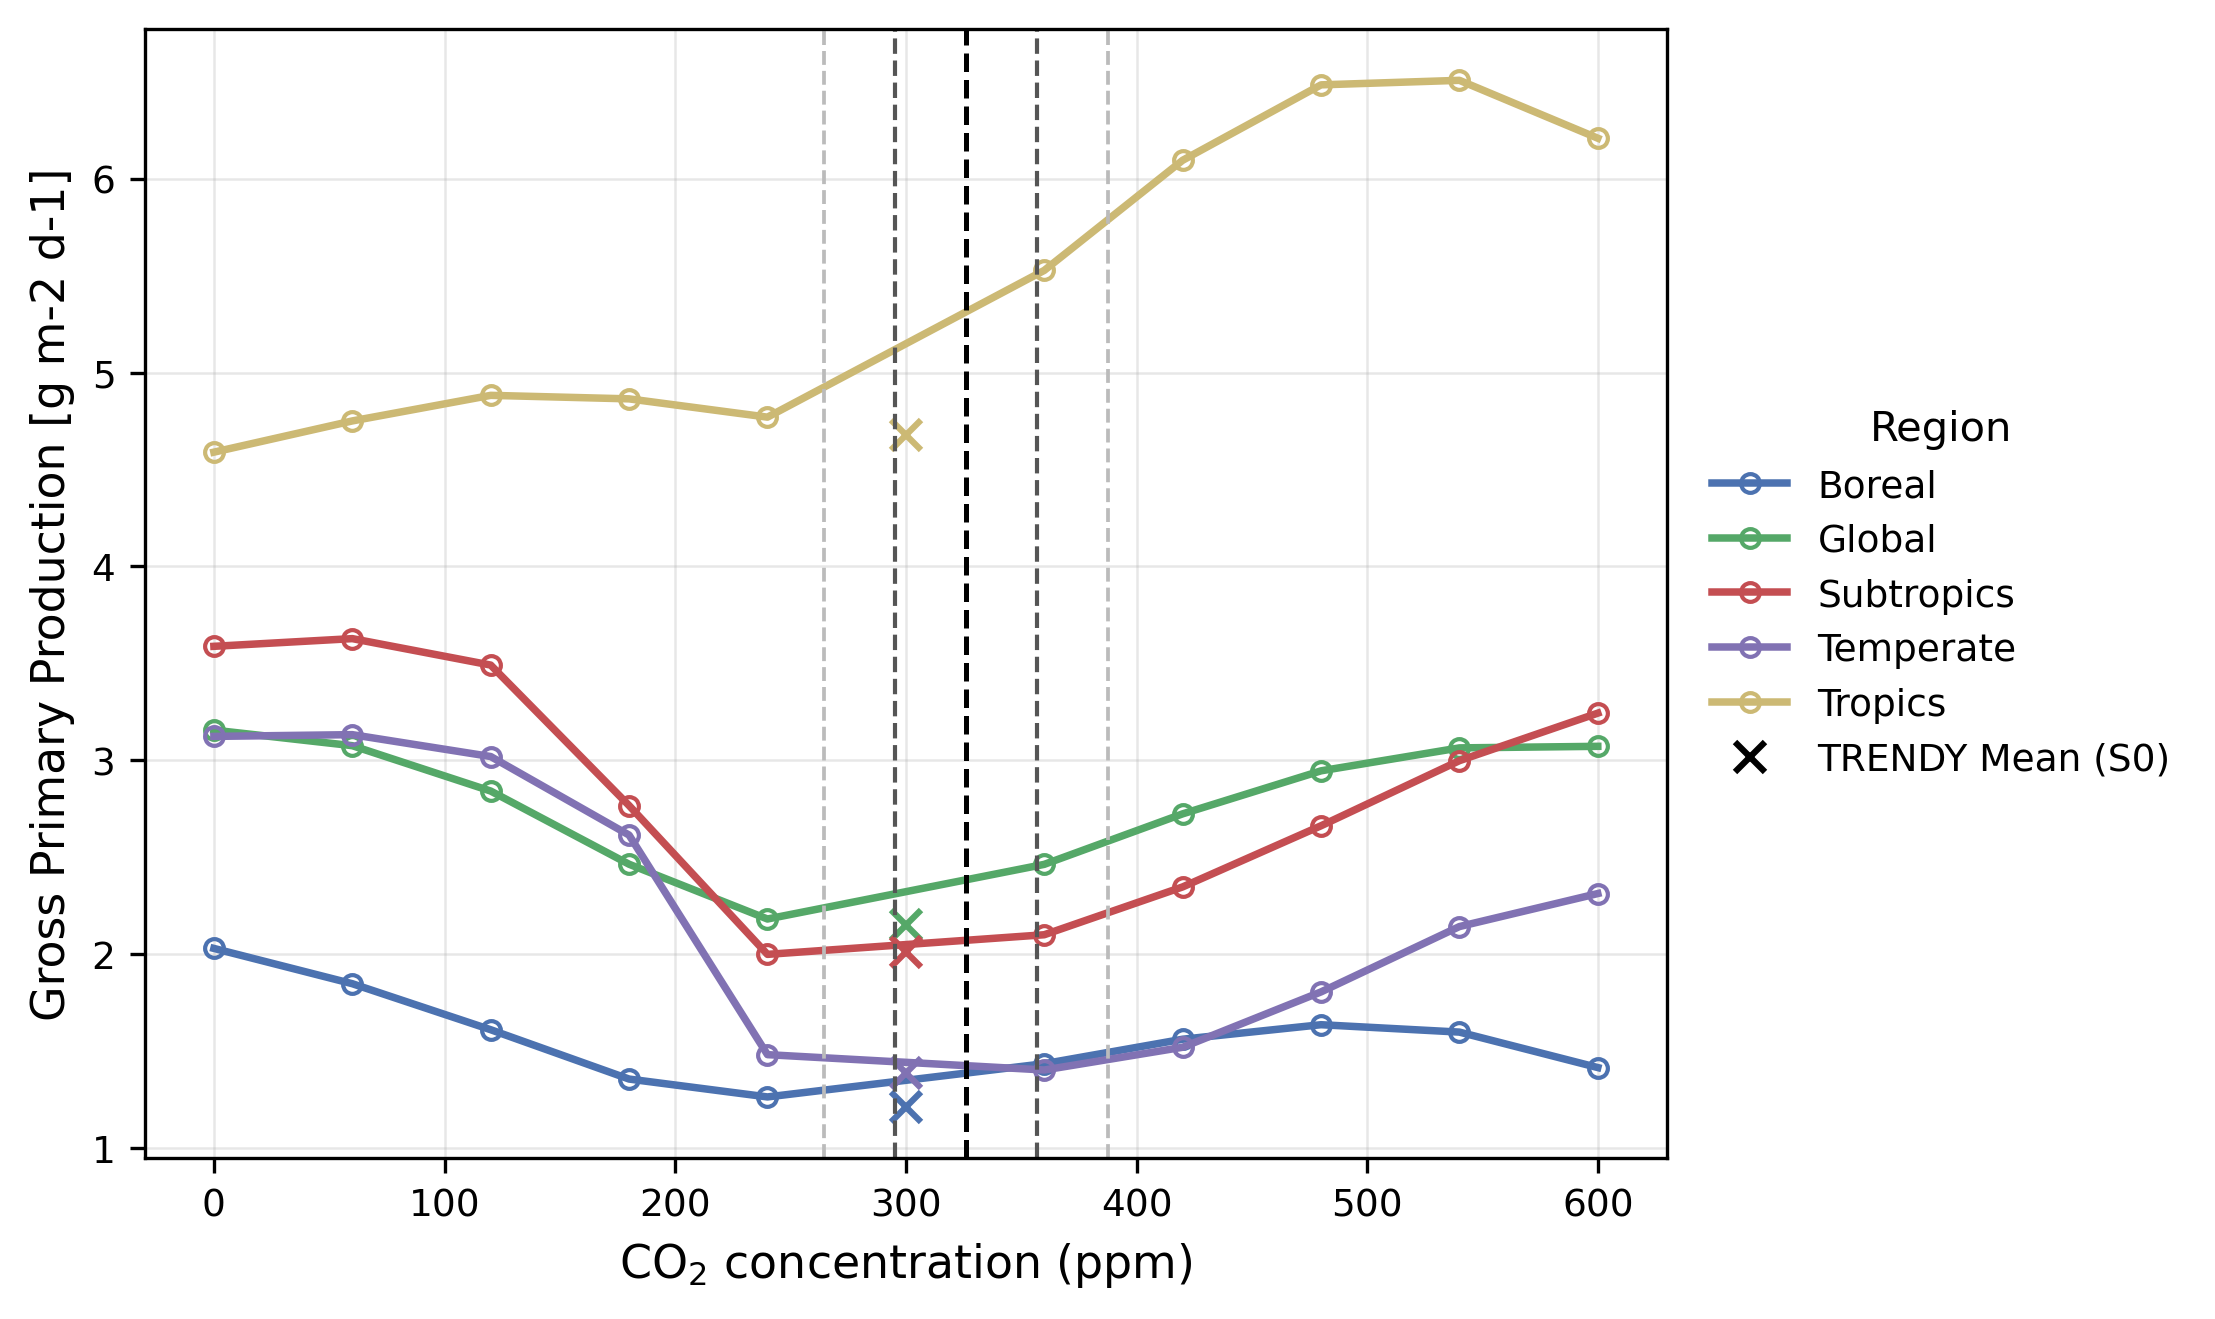

In [71]:
# Plot GPP response to CO2, with CO2 distribution lines
fig, ax = plot_variable_response(df, variable="GrossPrimaryProduction",
                                 forcing_var="co2")

In [ ]:
import json
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from cycler import cycler

def plot_variable_response_pre(df, variable, forcing_var="pre",
                           std_json_path=STD_JSON_PATH):
    """
    Plot Data vs Model for a given response variable.

    - Lines with circle markers for each Region where Type != 'Benchmark'
    - 'x' markers for Benchmark points in the same region colour (at 300 ppm)
    - Y label from output_attributes long_name + Units column
    - Vertical lines for the forcing_var distribution (from std_dict.json):
        * mean      -> black dashed
        * ±1 std    -> dark grey dashed
        * ±2 std    -> light grey dashed

    Parameters
    ----------
    df : pandas.DataFrame
        Must contain columns: ['Variable', 'Region', 'Type', 'Model', 'Data', 'Units', 'Experiment'].
    variable : str
        ILAMB variable label to plot (e.g. 'GrossPrimaryProduction', 'NetBiomeProductivity')
        or a key that can be mapped via VARIABLE_TO_KEY.
    forcing_var : str, default 'pre'
        Name of the forcing variable to look up in std_dict.json ('pre', 'tmp', or 'pre'),
        and to filter df['Experiment'].
    std_json_path : str
        Path to the std_dict.json file.
    """

    # ------------- Resolve variable label used in df -------------
    var_values = df['Variable'].unique()
    if variable in var_values:
        var_label = variable
    else:
        # Try mapping from a short key like "gpp"
        var_key = variable.lower()
        inv_map = {v.lower(): k for k, v in VARIABLE_TO_KEY.items()}
        if var_key in inv_map:
            var_label = inv_map[var_key]
        else:
            raise ValueError(
                f"Could not match variable '{variable}' to any df['Variable'] value "
                f"or VARIABLE_TO_KEY entry."
            )

    sub = df[df['Variable'] == var_label].copy()
    if sub.empty:
        raise ValueError(f"No rows found for Variable == '{var_label}'")

    # ------------- NEW: restrict to a single experiment -------------
    # Only keep rows where Experiment matches the forcing_var (e.g. 'pre')
    sub = sub[sub['Experiment'].str.lower() == forcing_var.lower()]
    if sub.empty:
        raise ValueError(
            f"No rows left after filtering for Experiment == '{forcing_var}'. "
            f"Check df['Experiment'] values."
        )

    # Units from the data
    units_vals = sub['Units'].dropna().unique()
    units = units_vals[0] if len(units_vals) > 0 else ""

    # Get long_name from output_attributes, if available
    key = VARIABLE_TO_KEY.get(var_label, None)
    if key is None:
        long_name = var_label
    else:
        long_name = output_attributes.get(key, var_label)

    # ------------- Figure + aesthetics -------------
    fig, ax = plt.subplots(figsize=(7.5, 4.5), dpi=300)

    # Muted, colour-blind-friendly palette
    palette = [
        "#4c72b0",  # blue
        "#55a868",  # green
        "#c44e52",  # red
        "#8172b3",  # purple
        "#ccb974",  # ochre
        "#64b5cd",  # light blue
        "#8c8c8c",  # grey
    ]
    ax.set_prop_cycle(cycler(color=palette))

    # Split model and benchmark rows
    model_rows = sub[sub['Type'] != 'Benchmark']
    bench_rows = sub[sub['Type'] == 'Benchmark']

    # ------------- Plot regional lines + benchmarks -------------
    regions = sorted(model_rows['Region'].dropna().unique())
    for region in regions:
        r_data = model_rows[model_rows['Region'] == region]
        if r_data.empty:
            continue

        r_data = r_data.sort_values('Model')

        # Line with hollow circle markers
        line, = ax.plot(
            r_data['Model'],
            r_data['Data'],
            marker='o',
            markersize=4.5,
            markerfacecolor='none',
            linewidth=1.8,
            linestyle='-',
            label=region.title(),  # capitalise in legend
        )
        color = line.get_color()

        # Benchmarks for this region at 300 ppm
        r_bench = bench_rows[bench_rows['Region'] == region]
        if not r_bench.empty:
            ax.plot(
                [300] * len(r_bench),
                r_bench['Data'],
                marker='x',
                linestyle='None',
                markersize=7,
                markeredgewidth=1.5,
                color=color,
            )

    # ------------- Vertical lines from std_dict.json -------------
    try:
        with open(std_json_path, "r") as f:
            std_dict = json.load(f)
    except FileNotFoundError:
        print(f"Warning: std_dict.json not found at {std_json_path}; "
              "skipping mean/std lines.")
        std_dict = {}

    forcing_key = forcing_var.lower()
    if forcing_key in std_dict:
        stats = std_dict[forcing_key]
        mean = stats["mean"]
        std = stats["std"]

        # Mean: black dashed
        ax.axvline(
            mean,
            color="black",
            linestyle="--",
            linewidth=1.2,
        )

        # ±1σ: dark grey
        for x in (mean - std, mean + std):
            ax.axvline(
                x,
                color="#555555",
                linestyle="--",
                linewidth=1.0,
            )

        # ±2σ: light grey
        for x in (mean - 2 * std, mean + 2 * std):
            ax.axvline(
                x,
                color="#bbbbbb",
                linestyle="--",
                linewidth=0.9,
            )
    else:
        print(f"Warning: '{forcing_key}' not found in std_dict.json; "
              "no mean/std lines drawn.")

    # ------------- Axes labels & grid -------------
    ax.set_xlabel(r"Precipitation Percentage Offset", fontsize=11)
    if units:
        ax.set_ylabel(f"{long_name} [{units}]", fontsize=11)
    else:
        ax.set_ylabel(long_name, fontsize=11)

    ax.grid(True, alpha=0.3, linewidth=0.6)
    ax.tick_params(labelsize=9)

    # ------------- Legend (outside, with benchmark entry) -------------
    handles, labels = ax.get_legend_handles_labels()

    # Add a global benchmark legend entry (black "x")
    benchmark_handle = Line2D(
        [], [], color='black', marker='x', linestyle='None',
        markersize=7, markeredgewidth=1.5, label='TRENDY Mean (S0)'
    )

    handles = handles + [benchmark_handle]
    labels = labels + ['TRENDY Mean (S0)']

    ax.legend(
        handles=handles,
        labels=labels,
        loc='center left',
        bbox_to_anchor=(1.02, 0.5),
        borderaxespad=0.0,
        frameon=False,
        title="Region",
        title_fontsize=10,
        fontsize=9,
    )

    fig.tight_layout()
    return fig, ax

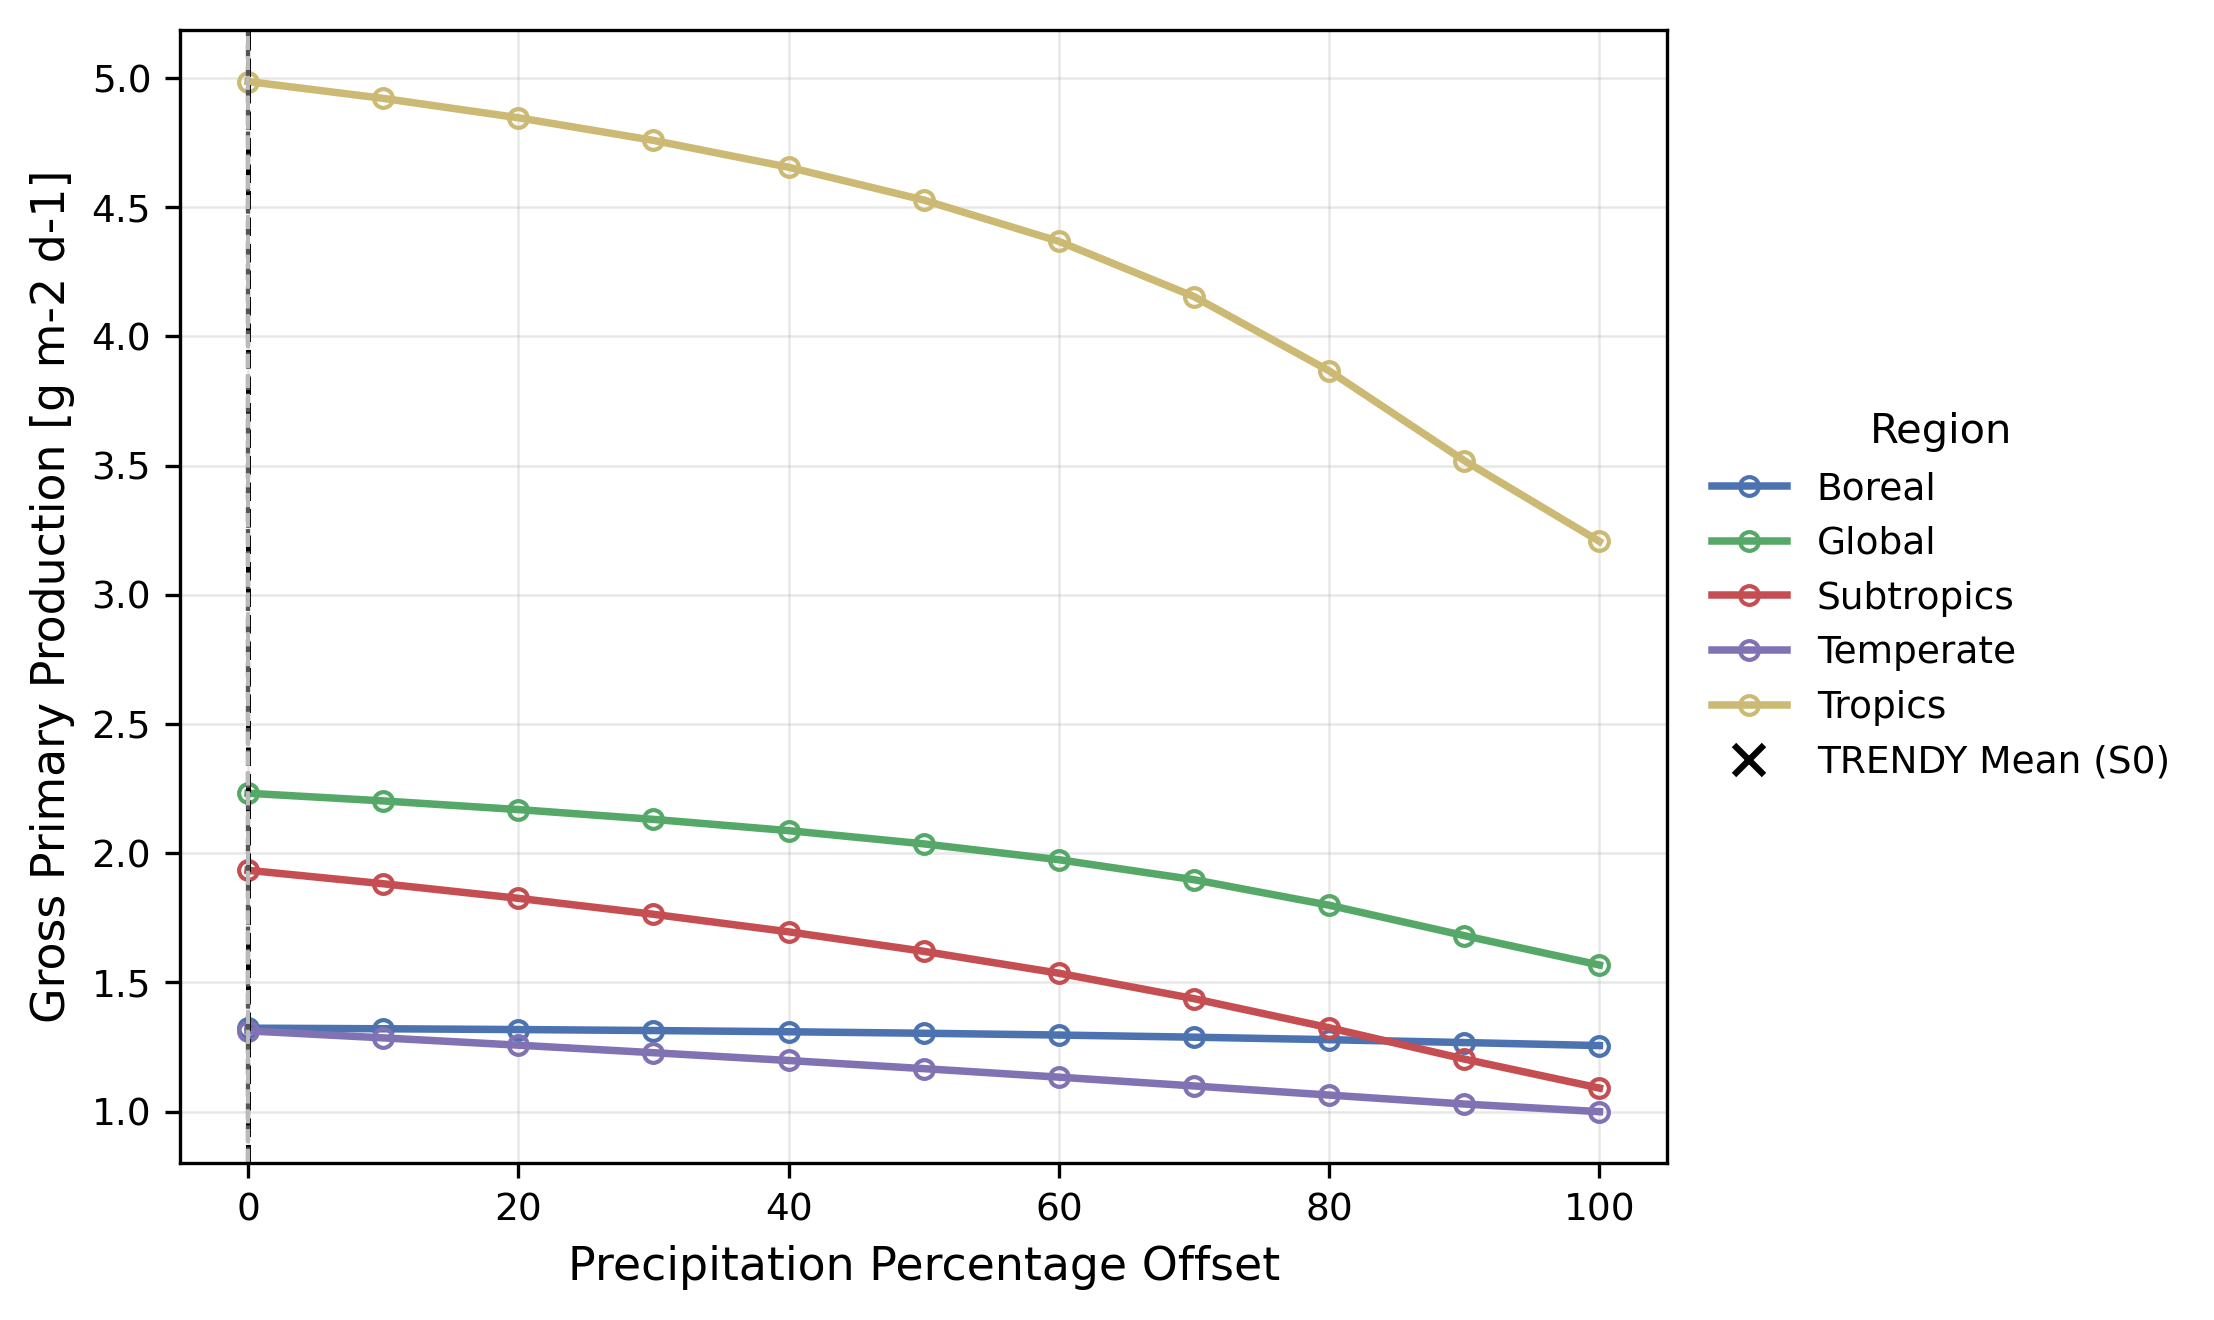

In [77]:
# Plot GPP response to CO2, with CO2 distribution lines
fig, ax = plot_variable_response_pre(df, variable="GrossPrimaryProduction",
                                 forcing_var="pre")

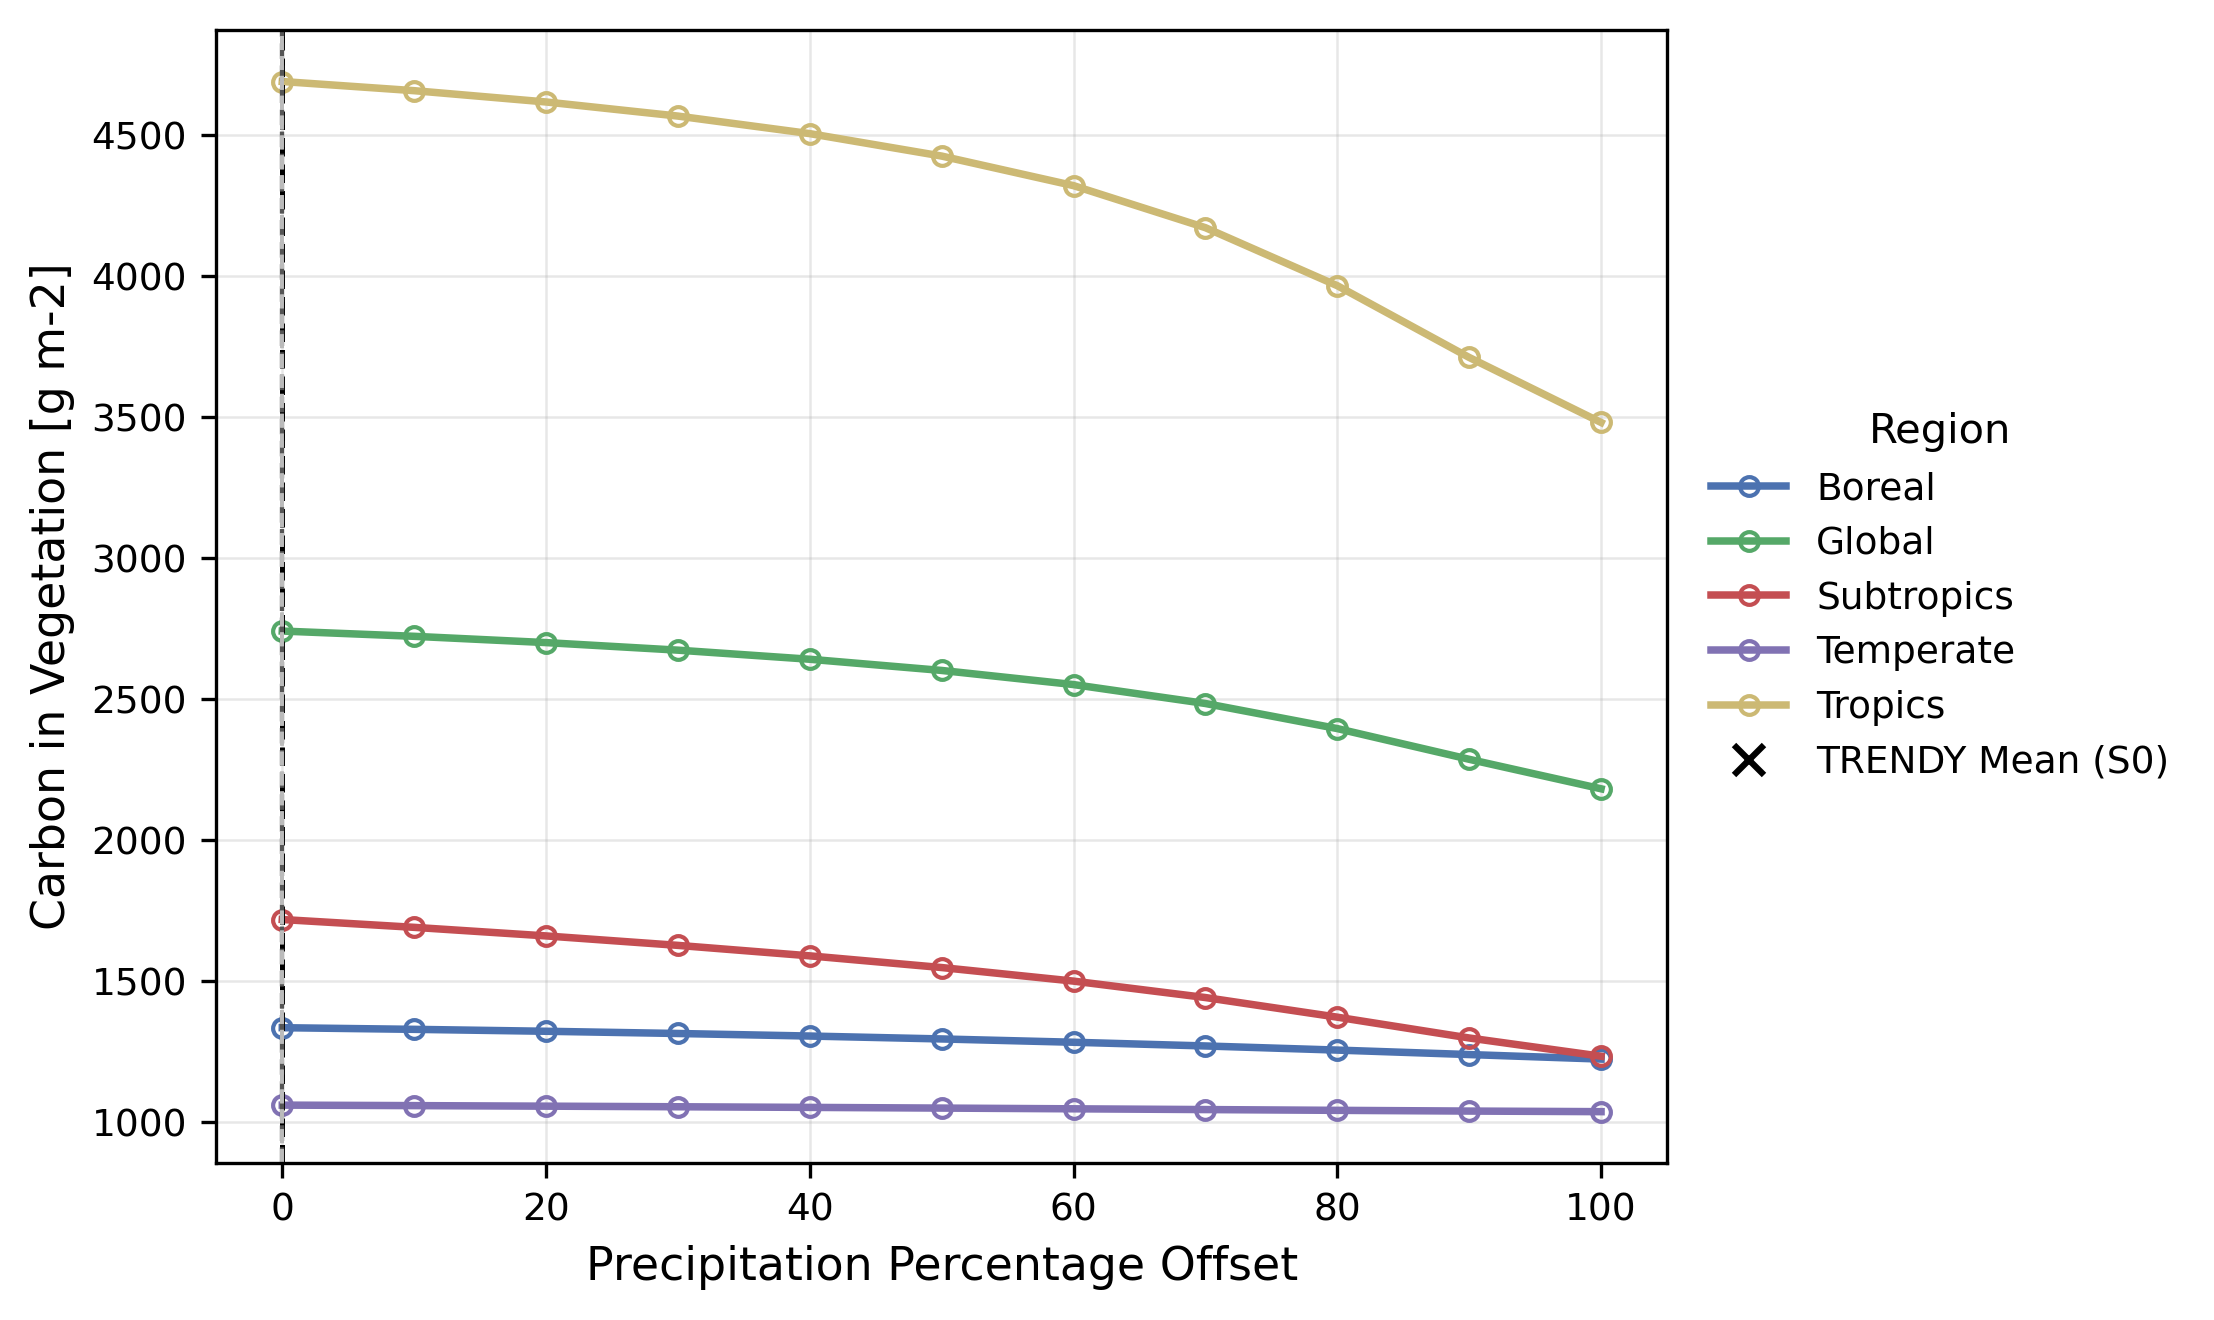

In [79]:
# Plot GPP response to CO2, with CO2 distribution lines
fig, ax = plot_variable_response_pre(df, variable="cVeg",
                                 forcing_var="pre")